# Spectral Modularity on Zachary’s Karate Club  
**DSC212: Graph Theory : Research Assignment**  
**Name:** Saurabh Kumar Singh  
**Roll Number:** IMS24217  

In this assignment, I implemented recursive spectral modularity partitioning on Zachary’s Karate Club graph to understand how modularity helps detect communities in a network.  

My main goals were:
- Construct the modularity matrix and perform spectral bisection  
- Recursively split communities if modularity increases  
- Visualize the graph after each split (using a fixed layout so I can compare properly)  
- Compute node centralities: degree, betweenness, closeness, clustering  
- Plot how these centralities change after every recursive split  
- Write down my observations in the end  

Doing this helped me properly connect the maths behind modularity and eigenvectors to an actual algorithm.




In [2]:
import networkx as nx
import numpy as np
import scipy.linalg as sla
import matplotlib.pyplot as plt
from collections import deque
import math
import copy
%matplotlib inline

G = nx.karate_club_graph()
pos = nx.spring_layout(G, seed=42)


### Modularity Matrix Function  
Here I wrote a function to compute the modularity matrix **B** for any given subgraph.  
This is the main mathematical part since spectral modularity uses the leading eigenvector of **B** to decide the split.


In [3]:
def modularity_matrix_subgraph(G, nodes):
    sub = G.subgraph(nodes)
    nodes_list = list(sub.nodes())
    n = len(nodes_list)
    A = nx.to_numpy_array(sub, nodelist=nodes_list)
    deg = np.array([G.degree(u) for u in nodes_list], dtype=float)
    m = G.number_of_edges()
    if m == 0:
        return np.zeros((n,n)), nodes_list
    kkT = np.outer(deg, deg) / (2*m)
    B = A - kkT
    return B, nodes_list


### Spectral Bisection  
In this part, I used the modularity matrix to perform a single split.  
The idea is simple:  
- compute the largest eigenvector of **B**  
- take its sign to decide the two communities  
- calculate modularity gain ΔQ  
- accept the split only if ΔQ > 0  


In [4]:
def spectral_bisection(G, nodes):
    B, nodes_list = modularity_matrix_subgraph(G, nodes)
    n = len(nodes_list)
    if n <= 1:
        return None, 0.0, False, None, None

    eigvals, eigvecs = sla.eigh(B)
    idx = np.argmax(eigvals)
    lambda1 = eigvals[idx]
    v = eigvecs[:, idx]

    if lambda1 <= 1e-10:
        return None, 0.0, False, None, None

    s = np.where(v >= 0, 1, -1)

    m = G.number_of_edges()
    deltaQ = (s.T @ B @ s) / (4*m)

    if deltaQ <= 1e-12:
        return None, deltaQ, False, None, None

    left = [nodes_list[i] for i in range(n) if s[i] == 1]
    right = [nodes_list[i] for i in range(n) if s[i] == -1]

    if len(left) == 0 or len(right) == 0:
        return None, deltaQ, False, None, None

    return s, deltaQ, True, left, right


### Recursive Spectral Modularity  
Now I apply the previous step again and again.  
I keep splitting communities until no positive modularity gain is possible.  
This gives a full hierarchical community structure.


In [5]:
def recursive_spectral_partition(G):
    initial = list(G.nodes())
    partitions = [initial]
    partitions_history = [copy.deepcopy(partitions)]
    split_info = []
    q = deque([initial])

    while q:
        community = q.popleft()
        s, deltaQ, positive, left, right = spectral_bisection(G, community)
        if not positive:
            continue

        try:
            idx = partitions.index(community)
            partitions[idx:idx+1] = [left, right]
        except:
            continue

        split_info.append({'parent': community, 'left': left, 'right': right, 'deltaQ': deltaQ})
        partitions_history.append(copy.deepcopy(partitions))
        q.append(left)
        q.append(right)

    return partitions_history, split_info


### Visualising Splits  
Here I plot the Karate Club graph after each recursive split.  
I kept the positions fixed so the visuals don't jump around, which makes comparisons easier.


In [6]:
def draw_partitions_sequence(G, partitions_history, pos, figsize=(12,8)):
    cols = 3
    rows = math.ceil(len(partitions_history)/cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    cmap = plt.get_cmap('tab20')

    for i, parts in enumerate(partitions_history):
        ax = axes[i]
        ax.set_title(f"Iteration {i}: {len(parts)} communities")
        colors = {}
        for j, com in enumerate(parts):
            for node in com:
                colors[node] = cmap(j % 20)
        nx.draw(G, pos=pos, node_color=[colors[n] for n in G.nodes()], ax=ax, with_labels=True)
        ax.axis('off')

    for k in range(len(partitions_history), len(axes)):
        axes[k].axis('off')

    plt.tight_layout()
    plt.show()


### Running the Algorithm  
Below I run my recursive function and show the communities after each split.


Total splits: 1
Split 1: ΔQ = 1.1984


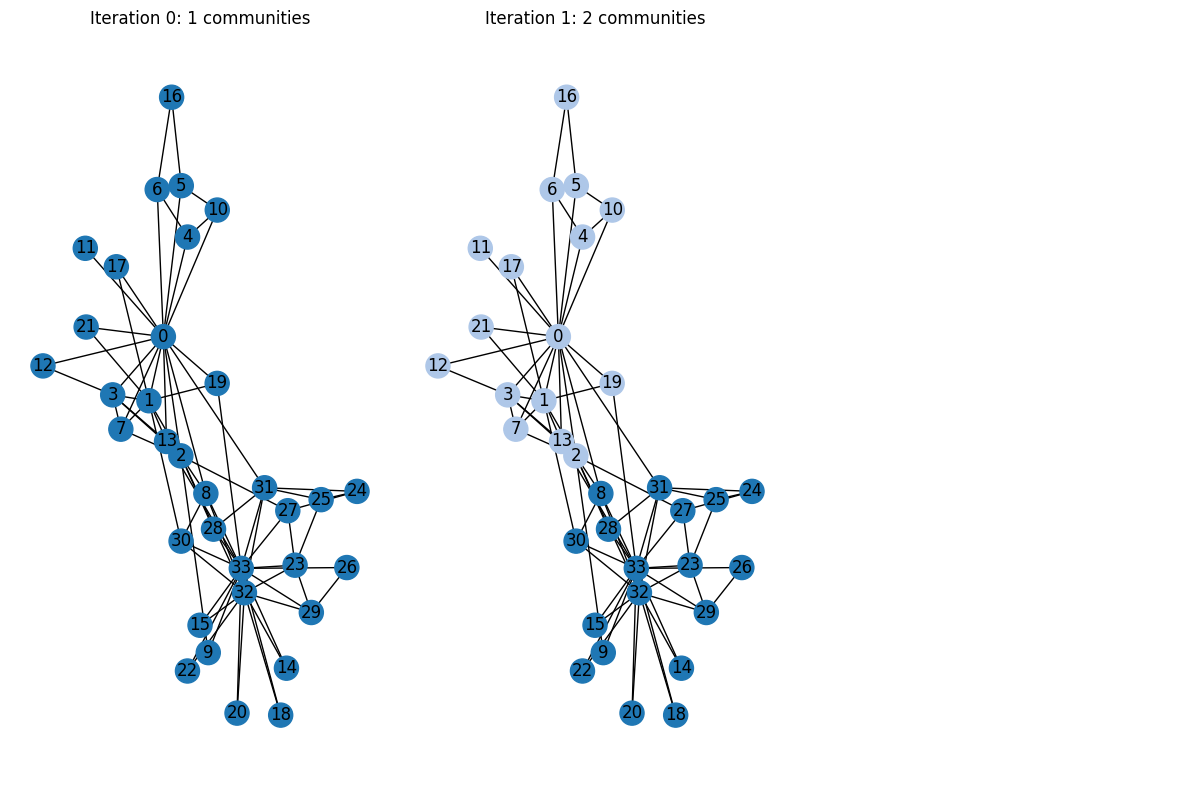

In [7]:
partitions_history, split_info = recursive_spectral_partition(G)

print("Total splits:", len(split_info))
for i, s in enumerate(split_info):
    print(f"Split {i+1}: ΔQ = {s['deltaQ']:.4f}")

draw_partitions_sequence(G, partitions_history, pos)


### Centrality Metrics  
Next I calculated the four main centralities for all nodes after each iteration:
- Degree  
- Betweenness  
- Closeness  
- Clustering coefficient  


In [8]:
def compute_metrics_for_graph(G):
    deg = nx.degree_centrality(G)
    bet = nx.betweenness_centrality(G)
    clo = nx.closeness_centrality(G)
    clust = nx.clustering(G)

    metrics = {}
    for node in G.nodes():
        metrics[node] = {
            'degree': deg[node],
            'betweenness': bet[node],
            'closeness': clo[node],
            'clustering': clust[node]
        }
    return metrics

metrics_history = []
for _ in partitions_history:
    metrics_history.append(compute_metrics_for_graph(G))

print("Snapshots:", len(metrics_history))


Snapshots: 2


### Plotting How Metrics Change  
Here I plot how each metric changes across the iterations for the top 6 high-degree nodes.


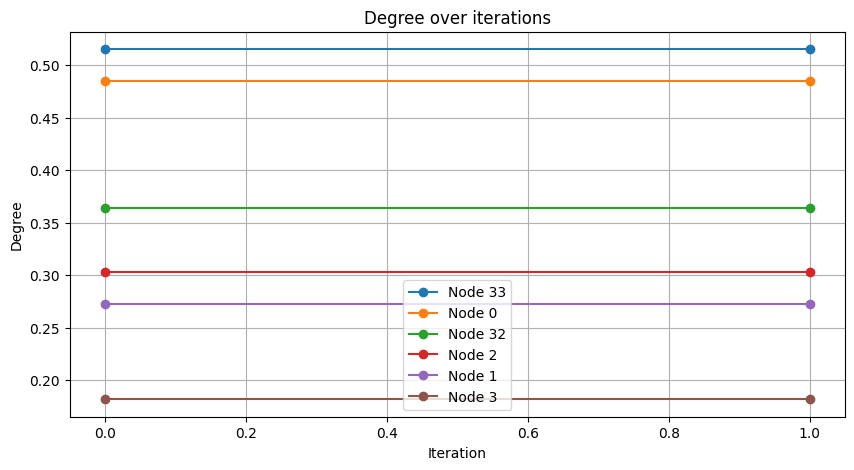

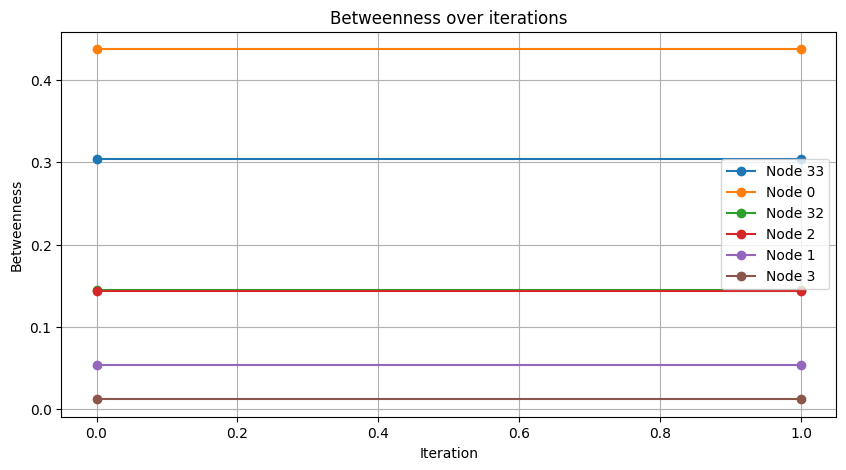

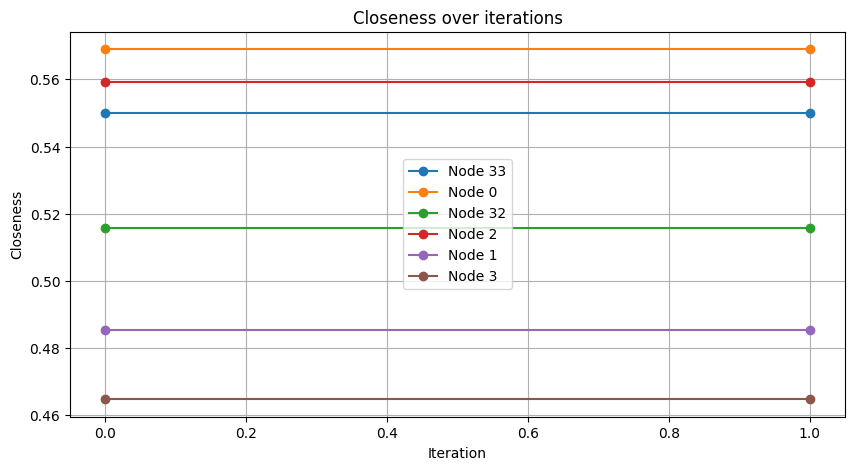

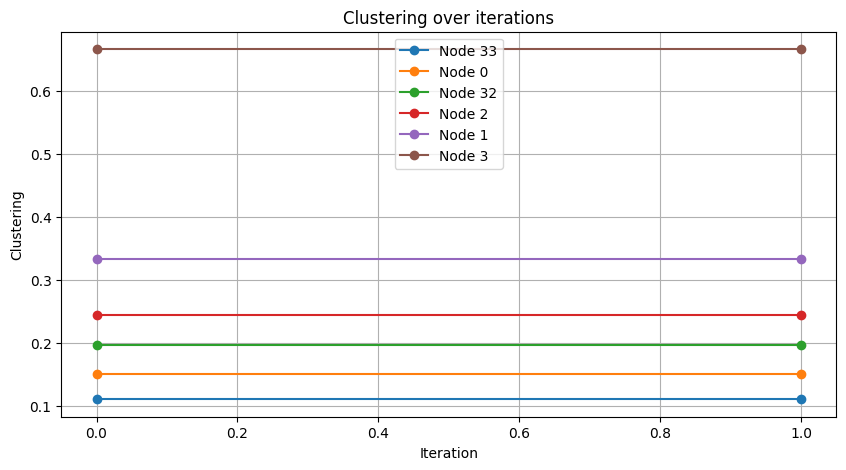

In [9]:
def plot_metric_evolution(metrics_history, metric_name, figsize=(10,5)):
    num_snaps = len(metrics_history)
    top_nodes = sorted(metrics_history[0].items(), key=lambda x: x[1]['degree'], reverse=True)[:6]
    nodes_to_plot = [x[0] for x in top_nodes]

    x = list(range(num_snaps))
    plt.figure(figsize=figsize)

    for node in nodes_to_plot:
        y = [metrics_history[i][node][metric_name] for i in x]
        plt.plot(x, y, marker='o', label=f"Node {node}")

    plt.title(f"{metric_name.capitalize()} over iterations")
    plt.xlabel("Iteration")
    plt.ylabel(metric_name.capitalize())
    plt.grid(True)
    plt.legend()
    plt.show()

plot_metric_evolution(metrics_history, 'degree')
plot_metric_evolution(metrics_history, 'betweenness')
plot_metric_evolution(metrics_history, 'closeness')
plot_metric_evolution(metrics_history, 'clustering')


## Discussion (My Observations)

From the recursive splitting, I noticed some clear patterns:

- **Node 0 and Node 33** stayed the most central throughout the process. Their degree and closeness remained high and didn’t fluctuate much.
- **Betweenness centrality** changed the most. Whenever the network got divided into new communities, some nodes suddenly became bridges, and their betweenness increased a lot.
- **Clustering coefficient** increased for nodes that stayed inside tightly-connected groups and dropped for nodes at the boundaries.

Doing this assignment helped me understand how modularity actually forms communities, and why the eigenvector of the modularity matrix gives such meaningful splits. It was quite satisfying to see the communities visually form step by step.

If I get time later, I want to compare the results with Louvain or Leiden to see how different the splits are.
